In [1]:
# basic dependencies
from pathlib import Path
if Path.cwd().parent.stem == 't3':
    %cd ..

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/compVision-DCC/t3
    
    assert torch.__version__.startswith("1.8")   
    try: 
        import detectron2
    except ImportError:
        !pip install pyyaml>=5.1
        !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
else:
    %config Completer.use_jedi = False

/home/step/Personal/UCH/2021-sem1/VisionComp/t3
1.7.1 True
gcc (GCC) 11.1.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
import io
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# Train on a custom dataset

## Prepare the dataset

Register the dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [4]:
from pathlib import Path
from detectron2.structures import BoxMode

def get_checks_dict_train(base_dir: str):
    base_dir = Path(base_dir)
    img_dir = Path(base_dir) / "images"
    annot_dir = Path(base_dir) / "annotations"

    dataset_dicts = []
    for idx, annot_f in enumerate(annot_dir.iterdir()):
        # print(annot)
        filename = annot_f.stem + '.png'
        filename = img_dir / filename
        height, width = cv2.imread(str(filename)).shape[:2]

        with open(annot_f) as f:
            img_annots = f.readlines()

        record = {}
        record["file_name"] = str(filename)
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        for annot in img_annots:
            # example: 4: 83, 8, 43, 53
            category_str, bbox_str = annot.split(':')
        
            bbox_str = bbox_str.split(',')
            bbox = [int(p_str.strip()) for p_str in bbox_str]

            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYWH_ABS,
                # "segmentation": [poly],
                "category_id": int(category_str),
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
data_path = Path('data/orand-car-with-bbs')

d = "train"
DatasetCatalog.register("checks_" + d, lambda d=d: get_checks_dict_train(data_path / d))
MetadataCatalog.get("checks_" + d).set(thing_classes=[str(i) for i in range(10)])


checks_metadata = MetadataCatalog.get("checks_train")

In [6]:
from detectron2.data.datasets.coco import register_coco_instances, convert_to_coco_dict
import json

checks_coco_dict = convert_to_coco_dict("checks_train")

with open('checks_coco.json', 'w') as fp:
    json.dump(checks_coco_dict, fp)

if not Path('cocosplit.py').exists():
    !wget https://raw.githubusercontent.com/akarazniewicz/cocosplit/master/cocosplit.py
!python cocosplit.py --having-annotations -s 0.9 checks_coco.json train.json test.json

register_coco_instances("checks-train", {}, "train.json", "")
register_coco_instances("checks-test", {}, "test.json", "")

[06/17 05:13:27 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/17 05:13:29 d2.data.datasets.coco]: Conversion finished, #images: 6370, #annotations: 31492
Saved 5733 entries in train.json and 637 in test.json


{'file_name': 'data/orand-car-with-bbs/train/images/0335_9010842_33296.png', 'image_id': 4527, 'height': 70, 'width': 920, 'annotations': [{'bbox': [97, 12, 35, 47], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 3}, {'bbox': [163, 11, 36, 50], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 3}, {'bbox': [251, 12, 33, 48], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 2}, {'bbox': [317, 12, 34, 46], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 9}, {'bbox': [382, 12, 37, 47], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 6}]}


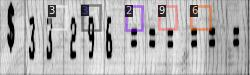

In [7]:
import detectron2.data.transforms as T

dataset_dicts = get_checks_dict_train(data_path / "train")
augs = T.AugmentationList([T.Resize((150, 500)), T.RandomContrast(1.5, 2.5)])

for d in random.sample(dataset_dicts,1):
    print(d)
    img = cv2.imread(d["file_name"])
    input = T.AugInput(img)
    transform = augs(input)  # type: T.Transform
    image_transformed = input.image  # new image
    
    visualizer = Visualizer(image_transformed[:, :, ::-1], metadata=checks_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    showarray(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [8]:
# !rm -r output_final/

In [9]:
from detectron2.engine import DefaultTrainer

from utils.trainer import MyTrainer
from TridentNet.tridentnet import add_tridentnet_config


cfg = get_cfg()
add_tridentnet_config(cfg)

cfg.merge_from_file('TridentNet/configs/tridentnet_fast_R_50_C4_3x.yaml')
cfg.DATASETS.TRAIN = ("checks-train",)
cfg.DATASETS.TEST = ("checks-test",)
cfg.TEST.EVAL_PERIOD = 250


cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00005  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate

cfg.MODEL.WEIGHTS = "models/best_mnist-trident.pth"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.MODEL.RPN.NMS_THRESH = 0.9
cfg.MODEL.RPN.BBOX_REG_WEIGHTS = (2.0, 2.5, 1.0, 1.0)
cfg.MODEL.RPN.LOSS_WEIGHT = 1.5 



# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.OUTPUT_DIR = './output_final'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
# trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/17 05:13:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

WARNING [06/17 05:13:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/17 05:13:36 d2.data.datasets.coco]: Loaded 5733 images in COCO format from train.json
[06/17 05:13:36 d2.data.build]: Removed 0 images with no usable annotations. 5733 images left.
[06/17 05:13:36 d2.data.build]: Distribution of instances among all 10 categories:
|  category  | #instances   | category   | #instances   | category   | #instances   |
|:----------:|:-------------|:-----------|:-------------|:-----------|:-------------|
|     0      | 8526         | 1          | 3168         | 2          | 2692         |
|     3      | 2328         | 4          | 2172         | 5          | 2438         |
|     6      | 1931         | 7          | 1704         | 8          | 1767         |
|     9      | 1590         |            |              |            |              |
|   total    | 28316        |            |              |            |        

AttributeError: module 'tensorflow.python.keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'

In [ ]:
from detectron2.utils.visualizer import ColorMode
from utils.trainer import InvertColors

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.7     # set a custom testing threshold
cfg.MODEL.RPN.NMS_THRESH = 0.3
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

predictor = DefaultPredictor(cfg)
i = 0
f = [(samp['file_name'], samp['annotations']) for samp in DatasetCatalog.get('checks-test')]

augs = T.AugmentationList(
    [
        InvertColors(),
        T.Resize((300,800)), 
        T.RandomContrast(1.5, 2.5),
        T.PadTransform(100, 100, 100, 100),
    ]
)

for file, categories in f:
    
    im = cv2.imread(file)
    categories = [cats['category_id'] for cats in categories]
    
    input = T.AugInput(im)
    transform = augs(input)  # type: T.Transform
    im = input.image  # new image
    
    if i == 3:
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                   metadata=checks_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        showarray(out.get_image()[:, :, ::-1])
        break
    i += 1

In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = 'output_final'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')

ax1.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x],
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x], color="red", label="Total Loss")

ax1.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x], color="blue", label="Val Loss")
    
ax1.tick_params(axis='y')
plt.legend(loc='upper left')
plt.show()


In [ ]:
from detectron2.checkpoint import Checkpointer
ckpt = Checkpointer(trainer.model, "models")
ckpt.save("best_checks-trident")